# Preprocessing Script

In [1]:
import pandas as pd
import numpy as np
import os
import csv
# Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# Keras
import keras

2024-03-04 11:22:53.745167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tkinter as tk
from tkinter import filedialog

### Saved Model Definition
This cell defines which saved model file will be loaded and the features of the system such as window size and channel trained on

## List of Models
ARIMA - Coming in V1.2

KNN - Coming in V1.2

Isolation Forest - Coming in V1.2

LSTM Predictor - Coming in V1.2

GAN - Coming in V1.2

Basic AE - Finished

CNN AE - Finished

Hybrid AE - Finished

LSTM AE - Finished

Transformer - Finished

VAE - Finished

In [3]:
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the small tkinter window

    current_working_directory = os.getcwd()
    folder = current_working_directory + '/Saved_models'
    file_path = filedialog.askopenfilename(initialdir=folder)

    if file_path:  # Check if a file was selected
        # Extract the filename from the full path
        filename = os.path.basename(file_path)
        return filename
    else:
        return None  # No file was selected

# Call the function and get the filename
filename = select_file()
filename, extension = os.path.splitext(filename)
if filename:
    print("Selected file:", filename)
else:
    print("No file was selected.")


Selected file: BasicAE_P-3_150


In [4]:
parts = filename.split('_')
print(parts)

['BasicAE', 'P-3', '150']


In [5]:
# Folder
model_folder = 'Saved_models/'
# Model
model_name = parts[0]
# Selected Channel
filename = parts[1]
# Feature Vector size
window_size = int(parts[2])

### Anomaly definition
This cell defines the stride of the window and the percentage of the window containing anomalies for it to be considered anomalous

In [6]:
# Number of datapoints to itterate in window generation
stride = 1
# Anomaly Window Threshold percentage
threshold = 0.7

### Data Path
Defines the path to the data file containing train and test data

In [7]:
path_train = './data/train/' + filename + '.npy'
path_test = './data/test/' + filename + '.npy'

s1 = os.path.getsize(path_train)
s2 = os.path.getsize(path_test)

data_train = np.load(path_train)
data_test = np.load(path_test)

### Loading Anomaly List
References the labeled_anomalies.csv file for where the anomalies are located

In [8]:
data = pd.read_csv (r'./labeled_anomalies.csv')
# Defining chan_id as index
data.set_index('chan_id', inplace = True)

# Data is loaded in as a string and must be converted to an array
filedata = data.loc[filename, 'anomaly_sequences']
if isinstance(filedata, str) == True:
    test = filedata.split(',')
else:
    test = filedata[0].split(',')

test[1].strip("[]")

counter = 0
anomaly_ranges = []
temp = []
for n in range(0, len(test)):
    temp.append(int(test[n].strip(' [] ')))
    counter += 1
    if counter == 2:
        anomaly_ranges.append(temp)
        temp = []
        counter = 0

print("Total number of labelled anomalies in dataset:", len(anomaly_ranges))
print("Ranges of anomalies: ", anomaly_ranges)

Total number of labelled anomalies in dataset: 1
Ranges of anomalies:  [[5401, 6736]]


### List Formation
The train and test datasets are formed into lists to be used later

In [9]:
ydata = []
for x in range (0, len(data_train)):
    ydata.append(data_train[x][0])
    
testdata = []
for x in range (0, len(data_test)):
    testdata.append(data_test[x][0])

### Rescaling
The original data is shaped 1 to -1, from previous work, scaling the data from 1 to 0 yields better results. They are then converted to numpy arrays

In [10]:
X_train = np.array(ydata).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
X_train_1D = X_train_norm.ravel()

X_test = np.array(testdata).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_test_norm = scaler.fit_transform(X_test)
X_test_1D = X_test_norm.ravel()

In [11]:
points_train = np.array(X_train_1D)
points_test = np.array(X_test_1D)

### Anomaly Ranges set as list
The anomaly ranges shown earlier are loaded as simple strings and need to be converted to referencable lists

In [12]:
test_list = []
print('Anomaly Ranges: ')
for n in range(0, len(anomaly_ranges)):
    test_list.append(anomaly_ranges[n][1] - anomaly_ranges[n][0])
    print(anomaly_ranges[n])
    
if (any(test_list) < window_size) == False:
    window_size = min(test_list) * threshold
    print('Resizing windows due to anomaly size\n New window size: ', window_size)

Anomaly Ranges: 
[5401, 6736]


### X_train Definition
X_train is now loaded as an array of datapoints for the length of the train dataset, with the window size number of points at each position. The array will look like (length_X_train, window_size)

In [13]:
X_train = []
temp = []
for y in range(0, len(ydata)-window_size, stride):
    end = window_size + y
    for x in range(y, end):
        temp.append(ydata[x])
    X_train.append(temp)
    temp = []

### X_test & y_test Definition
X_test & y_test is now loaded as an array of datapoints for the length of the train dataset, with the window size number of points at each position. The array will look like (length_X_test, window_size), (length_y_test, 1)

In [14]:
X_test = []
y_test = []
limit = window_size*threshold
temp = []

for y in range(0, len(points_test)-window_size, stride):
    end = window_size + y
    for x in range(y, end):
        temp.append(points_test[x])
    
    if len(anomaly_ranges) == 2:
        if y in range(anomaly_ranges[0][0] - int(limit), anomaly_ranges[0][1] + int(limit)) or y in range(anomaly_ranges[1][0] - int(limit), anomaly_ranges[1][1] + int(limit)):
            y_test.append(1)
        else:
            y_test.append(0)
    if len(anomaly_ranges) == 3:
        if y in range(anomaly_ranges[0][0] - int(limit), anomaly_ranges[0][1] + int(limit)) or y in range(anomaly_ranges[1][0] - int(limit), anomaly_ranges[1][1] + int(limit)) or y in range(anomaly_ranges[2][0] - int(limit), anomaly_ranges[2][1] + int(limit)):
            y_test.append(1)
        else:
            y_test.append(0)
    if len(anomaly_ranges) == 1:
        if y in range(anomaly_ranges[0][0] - int(limit), anomaly_ranges[0][1] + int(limit)):
            y_test.append(1)
        else:
            y_test.append(0)
            
    X_test.append(temp)
    temp = []

### Validataion Dataset Split
A validation dataset is created from the X_train data before the training step. 20% of the data is taken out of the training dataset and both are relabeled

In [15]:
X_val = X_train[:int(len(X_train)/20)]
X_train = X_train[int(len(X_train)/20):]

### NP Array Conversion
All datasets are now converted to numpy arays and the shapes of each are printed for confirmation

In [16]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_test= np.array(y_test)

print('X_train Shape: ', np.shape(X_train))
print('X_val Shape: ', np.shape(X_val))
print('X_test Shape: ', np.shape(X_test))
print('y_test Shape: ', np.shape(y_test))

X_train Shape:  (2570, 150)
X_val Shape:  (135, 150)
X_test Shape:  (8343, 150)
y_test Shape:  (8343,)


## Model Specific Pre-Processing
Automation of the preprocessing step based on model type

In [17]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [18]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [19]:
if model_name == 'CNNAE':
    features = 1  # Number of features (assuming one feature per time step)
    
    samples = X_train.shape[0]  # Number of samples
    time_steps = X_train.shape[1]  # Number of time steps
    X_train = X_train.reshape(samples, time_steps, features)

    samples = X_test.shape[0]  # Number of samples
    time_steps = X_test.shape[1]  # Number of time steps
    X_test = X_test.reshape(samples, time_steps, features)
    
    samples = X_val.shape[0]  # Number of samples
    time_steps = X_val.shape[1]  # Number of time steps
    X_val = X_val.reshape(samples, time_steps, features)
    
if model_name == 'HybridAE' or model_name == 'LSTMAE':
    timesteps = window_size
    n_features = window_size

    X, y = temporalize(X = X_train, y = np.zeros(len(X_train)), lookback = timesteps)

    X = np.array(X)
    X_train = X.reshape(X.shape[0], timesteps, n_features)
    
    X_t, y_t = temporalize(X = X_test, y = np.zeros(len(X_test)), lookback = timesteps)

    X_t = np.array(X_t)
    X_test = X_t.reshape(X_t.shape[0], timesteps, n_features)
    
    X_v, y_v = temporalize(X = X_val, y = np.zeros(len(X_val)), lookback = timesteps)

    X_v = np.array(X_v)
    X_val = X_v.reshape(X_v.shape[0], timesteps, n_features)

In [20]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_test= np.array(y_test)

print('X_train Shape: ', np.shape(X_train))
print('X_val Shape: ', np.shape(X_val))
print('X_test Shape: ', np.shape(X_test))
print('y_test Shape: ', np.shape(y_test))

X_train Shape:  (2570, 150)
X_val Shape:  (135, 150)
X_test Shape:  (8343, 150)
y_test Shape:  (8343,)


# Post Processing Script
Loads saved model file from the definitions at the beginning and prints a model summary to confirm model is loaded correctly

In [21]:
fullname = model_name + '_' + filename + "_" + str(window_size) + '.tflite'
fullname

'BasicAE_P-3_150.tflite'

In [22]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=fullname)
interpreter.allocate_tensors()

# Get input and output tensor information
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

### Training Dataset Reconstruction Error
Calculates training dataset reconstruction error and saves as recon_err_train

In [34]:
X_recon_train = []
for test_example in X_train:
    # Ensure the data is in the correct dtype expected by the model
    test_example = np.expand_dims(test_example, axis=0).astype(np.float32)
    
    # Set the model input tensor to the preprocessed test_example
    interpreter.set_tensor(input_details[0]['index'], test_example)
    
    # Run inference
    interpreter.invoke()
    
    # Extract the output tensor and remove the unnecessary dimension
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_data_squeezed = np.squeeze(output_data, axis=0)  # Removes the extra dimension
    
    # Append the result to the predictions list
    X_recon_train.append(output_data_squeezed)

# Convert predictions list to a numpy array
X_recon_train = np.array(X_recon_train)
recon_err_train = np.mean(np.power(X_train - X_recon_train, 2), axis=1)

### Test Dataset Reconstruction Error
Calculates Test dataset reconstruction error and saves as recon_err_test

In [36]:
X_recon = []
for test_example in X_test:
    # Ensure the data is in the correct dtype expected by the model
    test_example = np.expand_dims(test_example, axis=0).astype(np.float32)
    
    # Set the model input tensor to the preprocessed test_example
    interpreter.set_tensor(input_details[0]['index'], test_example)
    
    # Run inference
    interpreter.invoke()
    
    # Extract the output tensor and remove the unnecessary dimension
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_data_squeezed = np.squeeze(output_data, axis=0)  # Removes the extra dimension
    
    # Append the result to the predictions list
    X_recon.append(output_data_squeezed)

# Convert predictions list to a numpy array
X_recon = np.array(X_recon)
recon_err_test = np.mean(np.power(X_test - X_recon, 2), axis=1)

### Validation Dataset Reconstruction Error
Calculates validation dataset reconstruction error and saves as recon_err_val

In [37]:
X_recon_val = []
for test_example in X_val:
    # Ensure the data is in the correct dtype expected by the model
    test_example = np.expand_dims(test_example, axis=0).astype(np.float32)
    
    # Set the model input tensor to the preprocessed test_example
    interpreter.set_tensor(input_details[0]['index'], test_example)
    
    # Run inference
    interpreter.invoke()
    
    # Extract the output tensor and remove the unnecessary dimension
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_data_squeezed = np.squeeze(output_data, axis=0)  # Removes the extra dimension
    
    # Append the result to the predictions list
    X_recon_val.append(output_data_squeezed)

# Convert predictions list to a numpy array
X_recon_val = np.array(X_recon_val)
recon_err_val = np.mean(np.power(X_val - X_recon_val, 2), axis=1)

## Model Specific Post-processing

In [38]:
if model_name == 'HybridAE' or model_name == 'LSTMAE':
    result = []
    for e in recon_err_test:
        result.append(np.mean(e))
    recon_err_test = result
    zero = np.zeros(int((np.shape(X_train[1])[0]))+1)
    recon_err_test = np.concatenate((zero, recon_err_test))

### Reconstruction Error Threshold
Calculates the reconstruction error threshold to apply to test set predictions. If the value of the reconstruction error exceed the threshold, it is considered anomalous.

In [39]:
percentile = np.percentile(recon_err_test, 99.99)
thresholds = np.linspace(np.min(recon_err_test), percentile, 100)

In [40]:
f1s = []
for threshold in thresholds:
    y_pred = (recon_err_test > threshold).astype(int)
    f1s.append(f1_score(y_test, y_pred))

max_f1_index = np.argmax(f1s)
recon_threshold = thresholds[max_f1_index]

### y_pred declaration
Declares y_pred based on where the value exceeds the threshold

In [41]:
y_pred = []
for x in recon_err_test:
    y_hat = [1 if x > recon_threshold else 0]
    y_pred.append(y_hat)

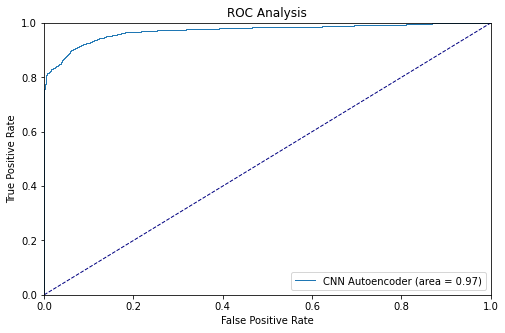

In [42]:
fpr, tpr, _ = roc_curve(y_test, recon_err_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
lw = 1
plt.plot(fpr, tpr,
         lw=lw, label='CNN Autoencoder (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

This cell gives the total results of the model after the threshold has been applied

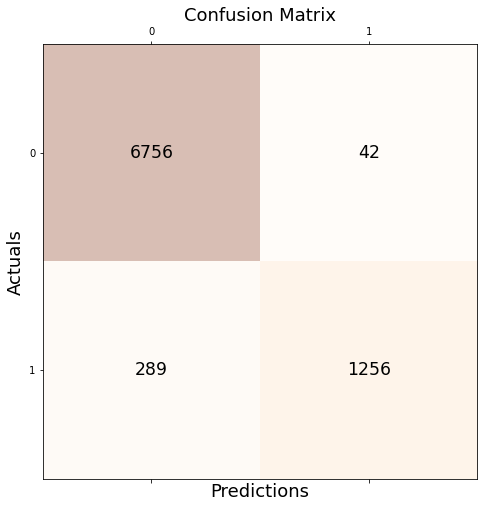

ROC Area: 0.972
F1 Score: 0.884
Accuracy: 0.960
Precision: 0.968
Recall: 0.813


In [43]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)


fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('ROC Area: %.3f' % roc_auc_score(y_test, recon_err_test))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))